# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "vendorProject" : "Vendor", "product" : "Product"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-2.0-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['vulnerabilities']:
            cve = entry['cve']['id']
            base_score = 0.0
            metrics = entry['cve'].get('metrics', {})
            cvss_v31 = metrics.get('cvssMetricV31', [{}])
            if cvss_v31 and 'cvssData' in cvss_v31[0]:
                base_score = cvss_v31[0]['cvssData'].get('baseScore', 0.0)
            new_row = {
                'CVE': cve,
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)

# Create DataFrame after all files are processed
nvd = pd.DataFrame(row_accumulator)
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3'])
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan)

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Vendor", "Product"]]

In [6]:
epss_kev_nvd

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2025-14733,9.8,0.31398,0.96602,WatchGuard Fireware OS iked process contains a...,WatchGuard,Firebox
1,CVE-2025-59374,9.8,0.30457,0.96527,ASUS Live Update contains an embedded maliciou...,ASUS,Live Update
2,CVE-2025-40602,6.6,0.01422,0.80132,SonicWall SMA1000 contains a missing authoriza...,SonicWall,SMA1000 appliance
3,CVE-2025-20393,10.0,0.04563,0.88826,"Cisco Secure Email Gateway, Secure Email, Asyn...",Cisco,Multiple Products
4,CVE-2025-59718,9.8,0.05948,0.90321,"Fortinet FortiOS, FortiSwitchMaster, FortiProx...",Fortinet,Multiple Products
...,...,...,...,...,...,...,...
1477,CVE-2021-27561,9.8,0.94106,0.99903,Yealink Device Management contains a server-si...,Yealink,Device Management
1478,CVE-2021-40539,9.8,0.94424,0.99979,Zoho ManageEngine ADSelfService Plus contains ...,Zoho,ManageEngine
1479,CVE-2020-10189,9.8,0.94248,0.99924,Zoho ManageEngine Desktop Central contains a f...,Zoho,ManageEngine
1480,CVE-2019-8394,6.5,0.87213,0.99415,Zoho ManageEngine ServiceDesk Plus (SDP) conta...,Zoho,ManageEngine


## CISA KEV Score Scatter Plot

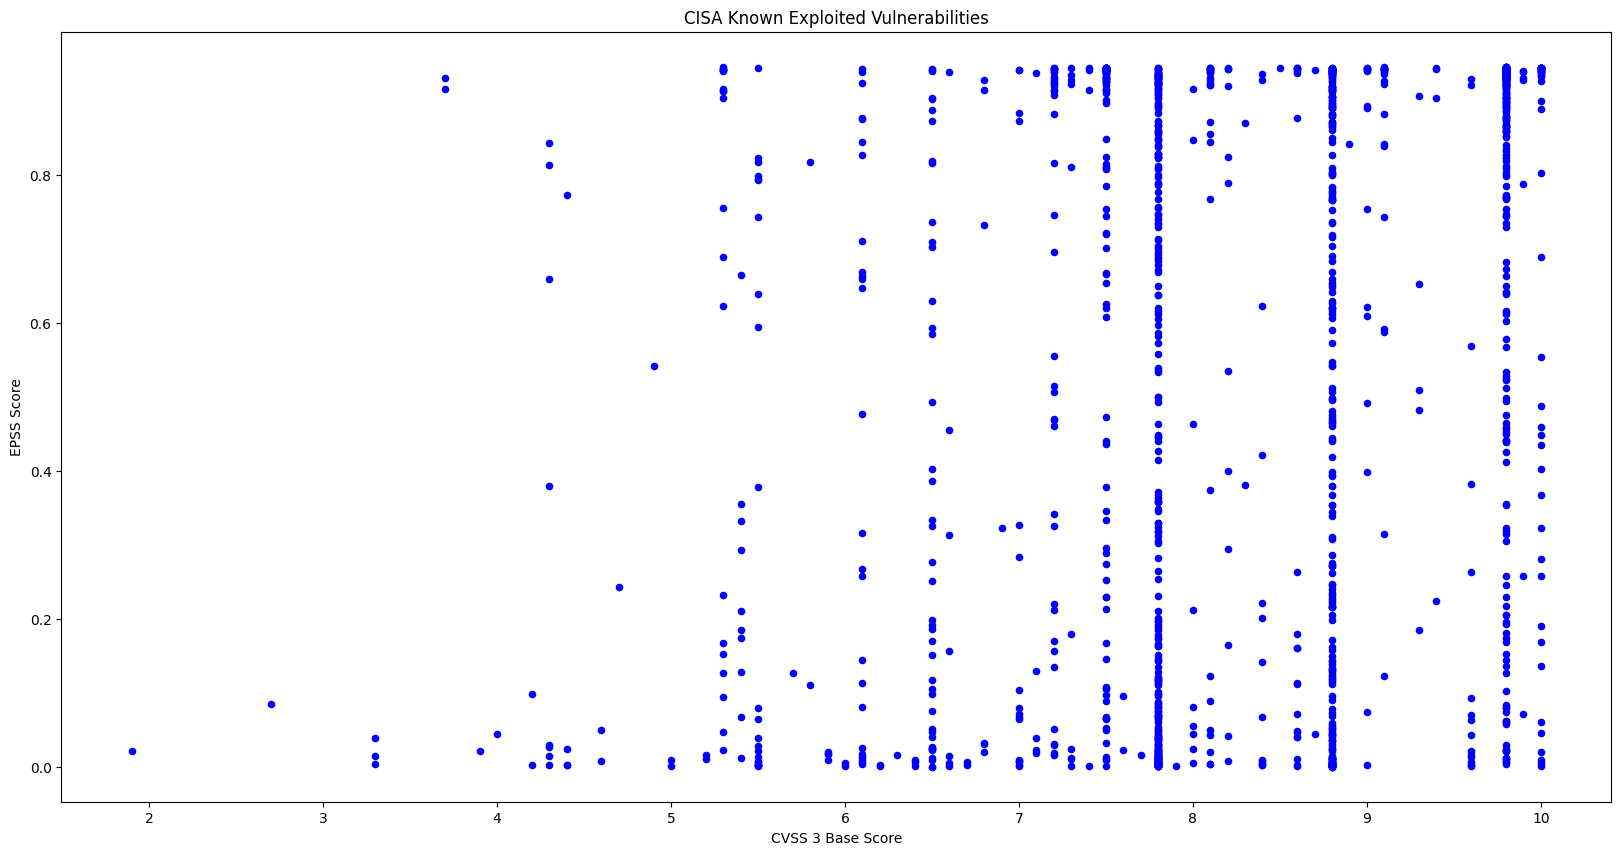

In [7]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                                 y='EPSS',
                                 figsize=(20, 10),
                                 title='CISA Known Exploited Vulnerabilities',
                                 color='blue')
ax.set_xlabel("CVSS 3 Base Score")
ax.set_ylabel("EPSS Score")
ax.get_figure().savefig('epss_kev_nvd.png')

## Export to CVS

In [8]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2025-14733,9.8,0.31398,0.96602,WatchGuard Fireware OS iked process contains a...,WatchGuard,Firebox
1,CVE-2025-59374,9.8,0.30457,0.96527,ASUS Live Update contains an embedded maliciou...,ASUS,Live Update
2,CVE-2025-40602,6.6,0.01422,0.80132,SonicWall SMA1000 contains a missing authoriza...,SonicWall,SMA1000 appliance
3,CVE-2025-20393,10.0,0.04563,0.88826,"Cisco Secure Email Gateway, Secure Email, Asyn...",Cisco,Multiple Products
4,CVE-2025-59718,9.8,0.05948,0.90321,"Fortinet FortiOS, FortiSwitchMaster, FortiProx...",Fortinet,Multiple Products
5,CVE-2025-14611,9.8,0.32270,0.96669,Gladinet CentreStack and TrioFox contain a har...,Gladinet,CentreStack and Triofox
6,CVE-2025-43529,8.8,0.00099,0.28325,"Apple iOS, iPadOS, macOS, and other Apple prod...",Apple,Multiple Products
7,CVE-2018-4063,8.8,0.01087,0.77376,Sierra Wireless AirLink ALEOS contains an unre...,Sierra Wireless,AirLink ALEOS
8,CVE-2025-14174,8.8,0.00530,0.66547,Google Chromium contains an out of bounds memo...,Google,Chromium
9,CVE-2025-58360,8.2,0.82347,0.99182,OSGeo GeoServer contains an improper restricti...,OSGeo,GeoServer
